In [66]:
import jupyter

In [67]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



In [68]:
# Configuration ======================
excluded_tickers = sorted(['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV'])

config = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0
}

run_settings = {
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date": "2023-12-31",
    "end_date": "2025-05-01",
    "seed": 314,
    "episode_length": 50,
    "noise_feature_cols": ["return_1d", "volume"],
    "train_steps": 10_000,
    "lookback": 0,
    
}

# System Boot =======================
DEVICE = boot()



In [69]:
# Load and Prepare Data ================
ohlcv_df = OHLCV_DF.copy()
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

# Filter Tickers ======================
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL"]  # Force test with AAPL
#tickers = TOP2_STOCK_BY_SECTOR
# Load and prepare trackers
ep_tracker    = EpisodeTracker()
env_tracker   = EnvironmentTracker()
agent_tracker = AgentTracker()

In [70]:
def add_lags(df,lags):
   
    df_lag = df.copy()
    for lag in range(1, lags + 1):
     
        df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag[f'volume_lag_{lag}'] = df_lag['volume_change'].shift(lag)
        df_lag[f'market_return_lag_{lag}'] = df_lag['market_return_1d'].shift(lag)
   
    #df_lag = df_lag.dropna()
    #print(df_lag)
    return df_lag


In [71]:
import numpy as np

def compute_returns_curve(curve):
    returns = np.diff(curve) / curve[:-1]
    return returns

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.mean(excess) / (np.std(excess) + 1e-8)

def sortino_ratio(returns, risk_free_rate=0.0):
    downside = returns[returns < risk_free_rate]
    return np.mean(returns - risk_free_rate) / (np.std(downside) + 1e-8)

def calmar_ratio(returns_curve):
    total_return = returns_curve[-1] / returns_curve[0] - 1
    drawdown = np.maximum.accumulate(returns_curve) - returns_curve
    max_drawdown = np.max(drawdown) / returns_curve[0]
    return total_return / (max_drawdown + 1e-8)


In [72]:
def extract_agent_diagnostics(env, model, mode='train'):
    rewards = []
    obs = env.reset()[0]
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)

    # Residual diagnostics
    oracle = env.oracle_progress
    agent = env.wallet_progress
    r = np.array(agent) - np.array(oracle)
    
    returns = env.wallet_progress
    market_returns =env.market_progress

    diagnostics = {
        f'{mode}_resid_std': np.std(r),
        f'{mode}_resid_skew': skew(r),
        f'{mode}_resid_kurtosis': kurtosis(r),
        f'{mode}_resid_acf1': pd.Series(r).autocorr(lag=1),
        f'{mode}_ljung_pval': acorr_ljungbox(r, lags=[min(10, len(r)-1)], return_df=True).iloc[0]['lb_pvalue'] if len(r) > 10 else np.nan,
        f'{mode}_resid_mean': np.mean(r),
        f'{mode}_resid_max': np.max(r),
        f'{mode}_resid_min': np.min(r),

        f'{mode}_sharpe': sharpe_ratio(returns),
        f'{mode}_sortino': sortino_ratio(returns),
        f'{mode}_calmar': calmar_ratio(agent),

        f'{mode}_market_sharpe': sharpe_ratio(market_returns),
        f'{mode}_market_sortino': sortino_ratio(market_returns),
        f'{mode}_market_calmar': calmar_ratio(env.market_progress),
    }

    return diagnostics


In [74]:
# Feature Extraction Loop ====================
features, targets, metadata ,runs= [], [], [],[]
def central_tendency_difference (mean,median):
    return abs(mean-median)/(abs(mean+median)/2)

for symbol in tqdm(tickers):
    df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
    df = df[df['date'] > run_settings['start_date']]
    df = df.iloc[:-run_settings["episode_length"]]
    months = df['month'].unique()
    # t stands for time
    # t1_ stands for time+1
    for i in range(len(months)):
        try:
            
            target_date = str(months[i])+'-01' 
            episodes = ep_tracker.findEpisode(
                target_date,
                symbol,
                episode_length=run_settings['episode_length'],
                lookback=run_settings['lookback'],
                mode='both')
            

            env_tracker = EnvironmentTracker()

            env_config = {
                "ticker": symbol,
                "n_timesteps": run_settings['episode_length'],
                "lookback":run_settings['lookback'],
                "market_features": ["close","price_change", "volume_change"],
                "seed": 314,
                "start_idx":ep['train']['df_start_iloc']
            }

            env_info = env_tracker.findEnvironment(version="v2", config=env_config)
            train_env = env_info['environment']
            env_config["start_idx"]=ep['test']['df_start_iloc']
            test_env = env_tracker.findEnvironment(version="v2", config=env_config)
            test_env = test_env['environment']

            
            tracker = AgentTracker()
            agent = tracker.findAgent(
                model_class="PPO",
                policy_class="MlpPolicy",
                config={ "verbose":1,"policy_kwargs": {"net_arch": [64, 64]}},
                #name="ppo_mlp_baseline"
            )
            _model = agent['model'].boot(train_env)
            _model.learn(total_timesteps=50_000)

            runs.append({
                "train_episode_id": episodes['train']['id'],
                "test_episode_id": episodes['test']['id'],
                'total_timesteps':50_000,
                'ticker':symbol,
                'target_date': target_date,
                'environment_id': env_info['id'],
                'agent_id': agent['id'],
                'model':_model,
                'train_env':train_env,
                'test_env':test_env,
            })
            #features.append(feat)
            #targets.append(cv_r2)
            #metadata.append({
            #    "symbol": symbol,
            #    "target_date": target_date,
            #    "train_episode_id": episodes['train']['episode_id'],
            #    "test_episode_id": episodes['test']['episode_id']
            #})

        except Exception as e:
            print(f"Skipping {symbol} {months[i]} due to error: {e}")
        except :
            print(months[i])
            


  0%|          | 0/1 [00:00<?, ?it/s]

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.311   |
| time/              |          |
|    fps             | 528      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | -0.0566     |
| time/                   |             |
|    fps                  | 476         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015396855 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss   

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 49        |
|    ep_rew_mean          | 2.19      |
| time/                   |           |
|    fps                  | 406       |
|    iterations           | 11        |
|    time_elapsed         | 55        |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.0021185 |
|    clip_fraction        | 0.0455    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.45     |
|    explained_variance   | 0.681     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0315    |
|    n_updates            | 100       |
|    policy_gradient_loss | 0.000709  |
|    value_loss           | 0.0673    |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.17  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.55         |
| time/                   |              |
|    fps                  | 399          |
|    iterations           | 21           |
|    time_elapsed         | 107          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0081998855 |
|    clip_fraction        | 0.0991       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.453       |
|    explained_variance   | 0.825        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0278      |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00356     |
|    value_loss           | 0.0451       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.03         |
| time/                   |              |
|    fps                  | 402          |
|    iterations           | 6            |
|    time_elapsed         | 30           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0046335803 |
|    clip_fraction        | 0.0575       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.527       |
|    explained_variance   | 0.138        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0111      |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00948     |
|    value_loss           | 0.148        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.13        |
| time/                   |             |
|    fps                  | 397         |
|    iterations           | 16          |
|    time_elapsed         | 82          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.003823829 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.37       |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00466     |
|    n_updates            | 150         |
|    policy_gradient_loss | 0.00374     |
|    value_loss           | 0.0804      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

Skipping AAPL 2024-02 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.155   |
| time/              |          |
|    fps             | 535      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 49         |
|    ep_rew_mean          | 0.0731     |
| time/                   |            |
|    fps                  | 417        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01435515 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.95         |
| time/                   |              |
|    fps                  | 397          |
|    iterations           | 11           |
|    time_elapsed         | 56           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0033238241 |
|    clip_fraction        | 0.05         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.387       |
|    explained_variance   | 0.593        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00276      |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00673     |
|    value_loss           | 0.1          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 49         |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 21         |
|    time_elapsed         | 110        |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 0.00628345 |
|    clip_fraction        | 0.0716     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0204    |
|    n_updates            | 200        |
|    policy_gradient_loss | 0.00219    |
|    value_loss           | 0.0375     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_re

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.04         |
| time/                   |              |
|    fps                  | 400          |
|    iterations           | 6            |
|    time_elapsed         | 30           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0057151727 |
|    clip_fraction        | 0.0895       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.559       |
|    explained_variance   | 0.137        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00438      |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.0153      |
|    value_loss           | 0.137        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.08         |
| time/                   |              |
|    fps                  | 391          |
|    iterations           | 16           |
|    time_elapsed         | 83           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0044455715 |
|    clip_fraction        | 0.0561       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.386       |
|    explained_variance   | 0.718        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000649    |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00323     |
|    value_loss           | 0.0835       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

Skipping AAPL 2024-04 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.0159  |
| time/              |          |
|    fps             | 539      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 0.0543      |
| time/                   |             |
|    fps                  | 479         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015173579 |
|    clip_fraction        | 0.145       |
|    clip_range      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.07         |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 11           |
|    time_elapsed         | 55           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0039016078 |
|    clip_fraction        | 0.0524       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.406       |
|    explained_variance   | 0.624        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0158      |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00403     |
|    value_loss           | 0.0839       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 398         |
|    iterations           | 21          |
|    time_elapsed         | 107         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.016933199 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.385      |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0081      |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00135     |
|    value_loss           | 0.0428      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 1.35        |
| time/                   |             |
|    fps                  | 406         |
|    iterations           | 6           |
|    time_elapsed         | 30          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.005837496 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.529      |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0174     |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.122       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49    

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 49         |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 399        |
|    iterations           | 16         |
|    time_elapsed         | 82         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.00748774 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.409     |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0185    |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.00354   |
|    value_loss           | 0.0768     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_m

Skipping AAPL 2024-06 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.217   |
| time/              |          |
|    fps             | 543      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 49         |
|    ep_rew_mean          | -0.0614    |
| time/                   |            |
|    fps                  | 413        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01331227 |
|    clip_fraction        | 0.0773     |
|    clip_range           | 0.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 1.94        |
| time/                   |             |
|    fps                  | 394         |
|    iterations           | 11          |
|    time_elapsed         | 57          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.004368996 |
|    clip_fraction        | 0.0654      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.456      |
|    explained_variance   | 0.686       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.011      |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00635    |
|    value_loss           | 0.0504      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.38        |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 21          |
|    time_elapsed         | 109         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.013374425 |
|    clip_fraction        | 0.0901      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.391      |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0718     |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00577    |
|    value_loss           | 0.0277      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 1.16        |
| time/                   |             |
|    fps                  | 407         |
|    iterations           | 6           |
|    time_elapsed         | 30          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.006352141 |
|    clip_fraction        | 0.0552      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.526      |
|    explained_variance   | 0.158       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0273      |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 0.166       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.41         |
| time/                   |              |
|    fps                  | 401          |
|    iterations           | 16           |
|    time_elapsed         | 81           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0038199327 |
|    clip_fraction        | 0.0588       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.341       |
|    explained_variance   | 0.845        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0156      |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.000735    |
|    value_loss           | 0.0425       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

Skipping AAPL 2024-08 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.0478  |
| time/              |          |
|    fps             | 403      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 0.118       |
| time/                   |             |
|    fps                  | 415         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013050708 |
|    clip_fraction        | 0.0646      |
|    clip_range      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.84         |
| time/                   |              |
|    fps                  | 398          |
|    iterations           | 11           |
|    time_elapsed         | 56           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0030393244 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.427       |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0206       |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00369     |
|    value_loss           | 0.109        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.56         |
| time/                   |              |
|    fps                  | 394          |
|    iterations           | 21           |
|    time_elapsed         | 109          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0071051596 |
|    clip_fraction        | 0.0767       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.374       |
|    explained_variance   | 0.932        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.015       |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00344     |
|    value_loss           | 0.0175       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.06         |
| time/                   |              |
|    fps                  | 381          |
|    iterations           | 6            |
|    time_elapsed         | 32           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0069241934 |
|    clip_fraction        | 0.0764       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.52        |
|    explained_variance   | 0.237        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0207       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.0112      |
|    value_loss           | 0.122        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.17         |
| time/                   |              |
|    fps                  | 341          |
|    iterations           | 16           |
|    time_elapsed         | 95           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0048013926 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.367       |
|    explained_variance   | 0.828        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0323      |
|    n_updates            | 150          |
|    policy_gradient_loss | 0.000271     |
|    value_loss           | 0.0374       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

Skipping AAPL 2024-10 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | 0.0799   |
| time/              |          |
|    fps             | 397      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 0.256        |
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0145075545 |
|    clip_fraction        | 0.129        |
|    clip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.13         |
| time/                   |              |
|    fps                  | 342          |
|    iterations           | 11           |
|    time_elapsed         | 65           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0036784997 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.4         |
|    explained_variance   | 0.631        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0228      |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00506     |
|    value_loss           | 0.0924       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.47        |
| time/                   |             |
|    fps                  | 334         |
|    iterations           | 21          |
|    time_elapsed         | 128         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.005624751 |
|    clip_fraction        | 0.0597      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.384      |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0229     |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00147    |
|    value_loss           | 0.0346      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.11         |
| time/                   |              |
|    fps                  | 249          |
|    iterations           | 6            |
|    time_elapsed         | 49           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0067047733 |
|    clip_fraction        | 0.0666       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.545       |
|    explained_variance   | 0.206        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0161       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.0106      |
|    value_loss           | 0.166        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 2.41         |
| time/                   |              |
|    fps                  | 301          |
|    iterations           | 16           |
|    time_elapsed         | 108          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0038012164 |
|    clip_fraction        | 0.0538       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.35        |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00991     |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00151     |
|    value_loss           | 0.0258       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

Skipping AAPL 2024-12 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.0938  |
| time/              |          |
|    fps             | 450      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 0.23        |
| time/                   |             |
|    fps                  | 364         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014831971 |
|    clip_fraction        | 0.123       |
|    clip_range      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.99         |
| time/                   |              |
|    fps                  | 336          |
|    iterations           | 11           |
|    time_elapsed         | 67           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0034722025 |
|    clip_fraction        | 0.0616       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.423       |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0466      |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00619     |
|    value_loss           | 0.0648       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.34        |
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 21          |
|    time_elapsed         | 128         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.007656101 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.413      |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0379      |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00408    |
|    value_loss           | 0.103       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 1.2          |
| time/                   |              |
|    fps                  | 391          |
|    iterations           | 6            |
|    time_elapsed         | 31           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0055612125 |
|    clip_fraction        | 0.0376       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.162        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0277       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00839     |
|    value_loss           | 0.16         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.39        |
| time/                   |             |
|    fps                  | 369         |
|    iterations           | 16          |
|    time_elapsed         | 88          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008615449 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.42       |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00848    |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0034     |
|    value_loss           | 0.0574      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49    

Skipping AAPL 2025-02 due to error: 'id'
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -0.0563  |
| time/              |          |
|    fps             | 472      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 49         |
|    ep_rew_mean          | 0.0541     |
| time/                   |            |
|    fps                  | 422        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01208479 |
|    clip_fraction        | 0.0356     |
|    clip_range           | 0.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.11        |
| time/                   |             |
|    fps                  | 349         |
|    iterations           | 11          |
|    time_elapsed         | 64          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.004298515 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.426      |
|    explained_variance   | 0.593       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00571    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00304    |
|    value_loss           | 0.108       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49          |
|    ep_rew_mean          | 2.52        |
| time/                   |             |
|    fps                  | 343         |
|    iterations           | 21          |
|    time_elapsed         | 125         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.011959765 |
|    clip_fraction        | 0.0738      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.888       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00164     |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00334     |
|    value_loss           | 0.0316      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49  

100%|██████████| 1/1 [35:03<00:00, 2103.75s/it]

Skipping AAPL 2025-03 due to error: 'id'


In [75]:
# VISUAÇ INSPECTION =====================

In [77]:
runs

[]

In [81]:
episodes['test']['episode_id']

1382

In [85]:
agent['id']

7

In [86]:
test_env.episode_df

,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,trade_count_change,sector_id,industry_id,return_1d,vix,vix_norm,sp500,sp500_norm,market_return_1d,month
0,33674,AAPL,2023-01-03 05:00:00,2023-01-03,130.280,130.9000,124.1700,125.07,124289279.0,1021067.0,...,0.727238,10.0,unknown,-0.037405,0.2290,0.056760,38.2414,-0.004001,-0.004001,2023-01
1,33675,AAPL,2023-01-04 05:00:00,2023-01-04,126.890,128.6557,125.0800,126.36,95426133.0,770045.0,...,-0.245843,10.0,unknown,0.010314,0.2201,-0.038865,38.5297,0.007539,0.007539,2023-01
2,33676,AAPL,2023-01-05 05:00:00,2023-01-05,127.130,127.7700,124.7600,125.02,88344592.0,665463.0,...,-0.135813,10.0,unknown,-0.010605,0.2246,0.020445,38.0810,-0.011646,-0.011646,2023-01
3,33677,AAPL,2023-01-06 05:00:00,2023-01-06,126.010,130.2900,124.8900,129.62,96468673.0,709888.0,...,0.066758,10.0,unknown,0.036794,0.2113,-0.059216,38.9508,0.022841,0.022841,2023-01
4,33678,AAPL,2023-01-09 05:00:00,2023-01-09,130.465,133.4100,129.8900,130.15,76653608.0,645367.0,...,-0.090889,10.0,unknown,0.004089,0.2197,0.039754,38.9209,-0.000768,-0.000768,2023-01
5,33679,AAPL,2023-01-10 05:00:00,2023-01-10,130.260,131.2636,128.1200,130.73,68415086.0,554942.0,...,-0.140114,10.0,unknown,0.004456,0.2058,-0.063268,39.1925,0.006978,0.006978,2023-01
6,33680,AAPL,2023-01-11 05:00:00,2023-01-11,131.250,133.5100,130.4600,133.49,77043246.0,561280.0,...,0.011421,10.0,unknown,0.021112,0.2109,0.024781,39.6961,0.012849,0.012849,2023-01
7,33681,AAPL,2023-01-12 05:00:00,2023-01-12,133.880,134.2600,131.4400,133.41,77698366.0,635333.0,...,0.131936,10.0,unknown,-0.000599,0.1883,-0.107160,39.8317,0.003416,0.003416,2023-01
8,33682,AAPL,2023-01-13 05:00:00,2023-01-13,132.030,134.9200,131.6600,134.76,63045132.0,535781.0,...,-0.156693,10.0,unknown,0.010119,0.1835,-0.025491,39.9909,0.003997,0.003997,2023-01
9,33683,AAPL,2023-01-17 05:00:00,2023-01-17,134.830,137.2900,134.1300,135.94,69852271.0,595834.0,...,0.112085,10.0,unknown,0.008756,0.1936,-0.006670,39.9097,-0.002030,-0.002030,2023-01


In [64]:
agent

{'agent_id': 6, 'id': 6, 'model': <tracker.Agent at 0x203d3e34110>}

In [45]:
ep_tracker = EpisodeTracker(df=OHLCV_DF)
ep= ep_tracker.findEpisode("2023-01-01",'AAPL',episode_length=120,mode="both")

env_tracker = EnvironmentTracker()

env_config = {
    "ticker": "AAPL",
    "n_timesteps": 120,
    "lookback": 0,
    "market_features": ["close","price_change", "volume_change"],
    #"full_df": "excluded",  # this will be ignored in hashing
    "seed": 314,
    "start_idx":ep['train']['df_start_iloc']
}

env_info = env_tracker.findEnvironment(version="v2", config=env_config)
train_env = env_info['environment']
env_config["start_idx"]=ep['test']['df_start_iloc']
test_env = env_tracker.findEnvironment(version="v2", config=env_config)
test_env = test_env['environment']


tracker = AgentTracker()
agent = tracker.findAgent(
    model_class="A2C",
    policy_class="MlpPolicy",
    config={ "verbose":1,"policy_kwargs": {"net_arch": [64, 64]}},
    #name="ppo_mlp_baseline"
)
_model = agent['model'].boot(train_env)
_model.learn(total_timesteps=50_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.234   |
| time/                 |          |
|    fps                | 403      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -9.6     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0758  |
|    value_loss         | 0.0135   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.193   |
| time/                 |          |
|    fps                | 443      |
|    iterations         | 200      |
|    time_elapsed 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.255   |
| time/                 |          |
|    fps                | 439      |
|    iterations         | 1400     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | 0.0161   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 0.00732  |
|    value_loss         | 0.000132 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | -0.258    |
| time/                 |           |
|    fps                | 435       |
|    iterations         | 1500      |
|    time_elapsed       | 17        |
|    total_timesteps    | 7500      |
| train/                |    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.25    |
| time/                 |          |
|    fps                | 426      |
|    iterations         | 2700     |
|    time_elapsed       | 31       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0.103    |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -0.0383  |
|    value_loss         | 0.00423  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | -0.258    |
| time/                 |           |
|    fps                | 424       |
|    iterations         | 2800      |
|    time_elapsed       | 32        |
|    total_timesteps    | 14000     |
| train/                |    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.262   |
| time/                 |          |
|    fps                | 429      |
|    iterations         | 4000     |
|    time_elapsed       | 46       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -22.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | -0.0382  |
|    value_loss         | 0.00552  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.258   |
| time/                 |          |
|    fps                | 429      |
|    iterations         | 4100     |
|    time_elapsed       | 47       |
|    total_timesteps    | 20500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.243   |
| time/                 |          |
|    fps                | 430      |
|    iterations         | 5400     |
|    time_elapsed       | 62       |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 7.82e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 5399     |
|    policy_loss        | 0.018    |
|    value_loss         | 0.0014   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.24    |
| time/                 |          |
|    fps                | 429      |
|    iterations         | 5500     |
|    time_elapsed       | 64       |
|    total_timesteps    | 27500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.255   |
| time/                 |          |
|    fps                | 428      |
|    iterations         | 6700     |
|    time_elapsed       | 78       |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0.00107  |
|    learning_rate      | 0.0007   |
|    n_updates          | 6699     |
|    policy_loss        | 0.038    |
|    value_loss         | 0.00305  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.256   |
| time/                 |          |
|    fps                | 427      |
|    iterations         | 6800     |
|    time_elapsed       | 79       |
|    total_timesteps    | 34000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.25    |
| time/                 |          |
|    fps                | 432      |
|    iterations         | 8000     |
|    time_elapsed       | 92       |
|    total_timesteps    | 40000    |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0.205    |
|    learning_rate      | 0.0007   |
|    n_updates          | 7999     |
|    policy_loss        | -0.0281  |
|    value_loss         | 0.00169  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.251   |
| time/                 |          |
|    fps                | 432      |
|    iterations         | 8100     |
|    time_elapsed       | 93       |
|    total_timesteps    | 40500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.274   |
| time/                 |          |
|    fps                | 435      |
|    iterations         | 9300     |
|    time_elapsed       | 106      |
|    total_timesteps    | 46500    |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 9299     |
|    policy_loss        | 0.0261   |
|    value_loss         | 0.00169  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.276   |
| time/                 |          |
|    fps                | 436      |
|    iterations         | 9400     |
|    time_elapsed       | 107      |
|    total_timesteps    | 47000    |
| train/                |          |
|

In [62]:
def extract_agent_residual_diagnostics(env, model, episode_id, total_timesteps):
    """
    Runs agent through environment and extracts residual diagnostics from reward trajectory.
    """
    rewards = []
    residuals = []
    predicted_scores = []

    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)

        # Optional: if info contains oracle reward, use it to calculate residual
        oracle_reward = info.get("oracle_score", None)  # custom if available
        if oracle_reward is not None:
            residuals.append(oracle_reward - reward)
        else:
            predicted_scores.append(reward)  # fallback

    # Use residuals if available, otherwise use deviations from mean reward
    if residuals:
        r = np.array(residuals)
    else:
        # Residual = reward - smoothed expected value
        smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
        r = np.array(rewards) - smoothed.values

    # Diagnostics
    diagnostics = {
        'episode_id': episode_id,
        'total_timesteps': total_timesteps,
        'resid_std': np.std(r),
        'resid_skew': skew(r),
        'resid_kurtosis': kurtosis(r),
        'resid_acf1': pd.Series(r).autocorr(lag=1),
        'ljung_pval': acorr_ljungbox(r, lags=[min(10, len(r)-1)], return_df=True).iloc[0]['lb_pvalue'] if len(r) > 10 else np.nan,
        'resid_mean': np.mean(r),
        'resid_max': np.max(r),
        'resid_min': np.min(r),
        'total_reward': 
    }

    return diagnostics

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import kurtosis, skew
import pandas as pd
import numpy as np

def extract_agent_residual_diagnostics(env, model, mode="train"):
    """
    Runs agent through environment and extracts residual diagnostics from reward trajectory.
    """
    rewards = []
    residuals = []
    predicted_scores = []

    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)

        # Optional: if info contains oracle reward, use it to calculate residual
        oracle_reward = info.get("oracle_score", None)  # custom if available
        if oracle_reward is not None:
            residuals.append(oracle_reward - reward)
        else:
            predicted_scores.append(reward)  # fallback

    # Use residuals if available, otherwise use deviations from mean reward
    if residuals:
        r = np.array(residuals)
    else:
        # Residual = reward - smoothed expected value
        smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
        r = np.array(rewards) - smoothed.values

    # Diagnostics
    diagnostics = {
   
        'resid_std': np.std(r),
        'resid_skew': skew(r),
        'resid_kurtosis': kurtosis(r),
        'resid_acf1': pd.Series(r).autocorr(lag=1),
        'ljung_pval': acorr_ljungbox(r, lags=[min(10, len(r)-1)], return_df=True).iloc[0]['lb_pvalue'] if len(r) > 10 else np.nan,
        'resid_mean': np.mean(r),
        'resid_max': np.max(r),
        'resid_min': np.min(r),
        'total_reward':env.total_reward
    }

    return diagnostics


In [61]:
extract_agent_residual_diagnostics(test_env, _model,mode="test")

AttributeError: 'PositionTradingEnvV2' object has no attribute 'oracle_progress'

<Axes: >

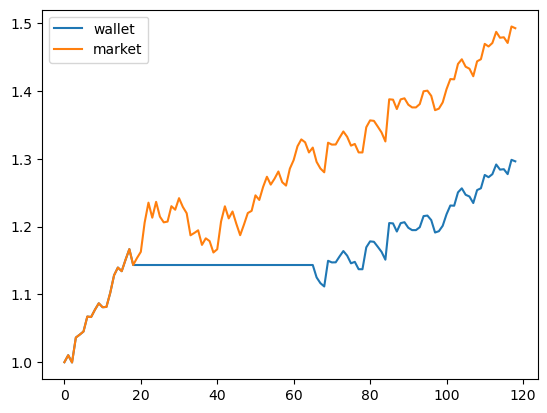

In [53]:
pd.DataFrame({"wallet":test_env.wallet_progress,"market":test_env.market_progress}).plot()

<Axes: >

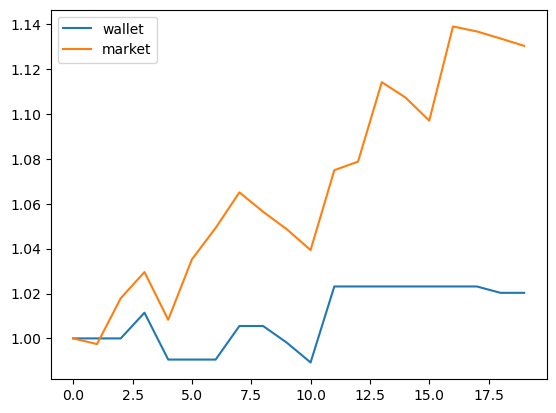

In [54]:
pd.DataFrame({"wallet":train_env.wallet_progress,"market":train_env.market_progress}).plot()

In [63]:
extract_agent_residual_diagnostics(test_env, _model,1,50_000)

{'episode_id': 1,
 'total_timesteps': 50000,
 'resid_std': 0.022153556630321154,
 'resid_skew': 2.174661924038488,
 'resid_kurtosis': 11.858391049433063,
 'resid_acf1': -0.0059109993388918,
 'ljung_pval': 0.023712071828428258,
 'resid_mean': -0.00012188758973505165,
 'resid_max': 0.13616276739433364,
 'resid_min': -0.05959002619002053}

<Axes: >

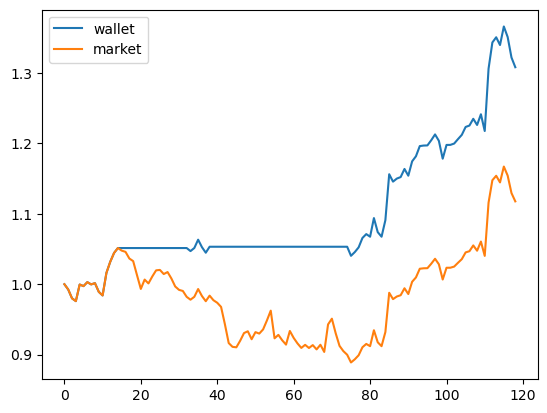

In [17]:
pd.DataFrame({"wallet":test_env.wallet_progress,"market":test_env.market_progress}).plot()

| Metric           | Value    | Visual Match / Interpretation                                        |
| ---------------- | -------- | -------------------------------------------------------------------- |
| `resid_std`      | `0.0367` | ✅ Stable across most steps — no huge swings until later              |
| `resid_skew`     | `4.23`   | 🔥 The *big gains* late in the episode cause the **positive tail**   |
| `resid_kurtosis` | `30.34`  | 💥 Those late sharp jumps are **rare** and **extreme outliers**      |
| `resid_acf1`     | `0.03`   | 🧘 Almost no autocorrelated error — agent is not trapped in patterns |
| `ljung_pval`     | `0.39`   | ✅ Residuals pass autocorrelation test — good generalization          |
| `resid_mean`     | ≈ `0`    | ✅ Unbiased — no systemic overshooting or undershooting               |
| `resid_max`      | `0.284`  | 🚀 The spike near the end — massive outperformance of expected       |
| `resid_min`      | `−0.085` | ⚠️ Small dip somewhere in the midsection — tolerable                 |


In [13]:
cccccccccccccccc

NameError: name 'cccccccccccccccc' is not defined

In [13]:
X = df_t1[
        [f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]+
        [f'volume_lag_{i}' for i in range(1, run_settings['lags'] + 1)]+
        [f'market_return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]
    ].values
X.shape[:10]

(50, 15)

In [ ]:
# episode_benchmarking_engine.py

import os
import json
import hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from typing import Optional, Dict, List
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from environments import PositionTradingEnv,PositionTradingEnvV1,PositionTradingEnvV2

# Updated utility functions

def generate_lagged_features(df, config):
    df = df.copy()
    if config.get('return'):
        df['return_1d'] = df['close'].pct_change()
    if config.get('volume'):
        df['volume_1d'] = df['volume'].pct_change()
    for lag in range(1, config.get('lags', 0) + 1):
        df[f'return_lag_{lag}'] = df['return_1d'].shift(lag)
        df[f'volume_lag_{lag}'] = df['volume_1d'].shift(lag)
    return df.dropna()

def compute_sharpe_ratio(returns):
    mean = np.mean(returns)
    std = np.std(returns)
    return mean / std if std > 0 else np.nan

def compute_sortino_ratio(returns):
    mean = np.mean(returns)
    downside_std = np.std(returns[returns < 0])
    return mean / downside_std if downside_std > 0 else np.nan

def compute_calmar_ratio(returns):
    cum_returns = np.cumprod(1 + returns)
    drawdown = np.max(cum_returns) - np.min(cum_returns)
    mean_return = np.mean(returns)
    return mean_return / drawdown if drawdown > 0 else np.nan



# Utility functions with real logic for agent and oracle evaluation
def compute_agent_metrics(model, env, random=False):
    obs, _ = env.reset()
    done, actions, values = False, [], []
    while not done:
        action = env.action_space.sample() if random else model.predict(obs, deterministic=True)[0]
        obs, reward, done, _, info = env.step(action)
        actions.append(action)

    values = np.array(env.env.wallet_progress)
    if len(values) < 2:
        return {}
   
    returns = values-1 #np.diff(values) #/ (values[:-1] + 1e-9)
    negative_returns = returns[returns < 0] if len(returns[returns < 0]) > 0 else np.array([1e-9])
    action_probs = np.bincount(actions, minlength=2) / (len(actions) + 1e-9)
    drawdowns = values / np.maximum.accumulate(values)
    max_drawdown = drawdowns.min() - 1 if len(drawdowns) > 0 else -1
    success_trades = env.env.success_trades = 0
    failed_trades = env.env.failed_trades = 0
    total_trades = env.env.total_trades = 0
  
    sharpe = 0
    sortino = 0
    calmar = 0
    if returns.std() !=0:
        sharpe = returns.mean() / (returns.std() + 1e-9) * np.sqrt(252)
        sortino = returns.mean() / (negative_returns.std() + 1e-9) * np.sqrt(252)
   
    return {
        "reward": env.env.total_reward,
        "volatility": returns.std(),
        "entropy": -np.sum(action_probs * np.log2(action_probs + 1e-9)),
        "max_drawdown": max_drawdown,
        "sharpe": sharpe, #returns.mean() / (returns.std() + 1e-9) * np.sqrt(252),
        "sortino": sortino, #returns.mean() / (negative_returns.std() + 1e-9) * np.sqrt(252),
        "calmar": returns.mean() / abs(max_drawdown + 1e-9),
        "success_trades": success_trades,
        "action_hold_ratio": np.mean(np.array(actions) == 0),
        "action_long_ratio": np.mean(np.array(actions) == 1),
        "cumulative_return": values[-1] / values[0] - 1 if values[0] != 0 else 0
    }

def compute_oracle_metrics(env):
    obs, _ = env.reset()
    done, actions, values = False, [], []
    

    while not done:
        curr_idx = env.env.step_idx
        next_idx = min(curr_idx + 1, len(env.env.prices) - 1)
        curr_price = env.env.prices[curr_idx]
        next_price = env.env.prices[next_idx]
        price_diff = next_price - curr_price
        action = 1 if price_diff > 0 else 0
        #action = episode_df.iloc[env.current]  # oracle always assumes uptrend (long)
        obs, reward, done, _, info = env.step(action)
        actions.append(action)

    values = np.array(env.env.wallet_progress)
    if len(values) < 2:
        return {}
    #print(values,actions)
    returns = values #np.diff(values) / (values[:-1] + 1e-9)
    negative_returns = returns[returns < 1] if len(returns[returns < 1]) > 0 else np.array([1e-9])
    action_probs = np.bincount(actions, minlength=2) / (len(actions) + 1e-9)
    drawdowns = values / np.maximum.accumulate(values)
    max_drawdown = drawdowns.min() - 1 if len(drawdowns) > 0 else -1

    success_trades = 0
    fail_trades = 0
    total_trades = 0
  

    return {
        "oracle_volatility": returns.std(),
        "oracle_entropy": -np.sum(action_probs * np.log2(action_probs + 1e-9)),
        "oracle_max_drawdown": max_drawdown,
        "oracle_sharpe": returns.mean() / (returns.std() + 1e-9) * np.sqrt(252),
        "oracle_sortino": returns.mean() / (negative_returns.std() + 1e-9) * np.sqrt(252),
        "oracle_calmar": returns.mean() / abs(max_drawdown + 1e-9),
        "oracle_success_trades": success_trades,
        "oracle_action_hold_ratio": np.mean(np.array(actions) == 0),
        "oracle_action_long_ratio": np.mean(np.array(actions) == 1),
        "oracle_cumulative_return": values[-1] / values[0] - 1 if values[0] != 0 else 0
    }



def compute_additional_diagnostics(env):
    df = env.env.episode_df
    df = generate_lagged_features(df.copy(), {'return': True, 'volume':True,'lags': 5})
    df = df.dropna()
    X = df[[f'return_lag_{i}' for i in range(1, 6)]].values
    y = df['return_1d'].values
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    residuals = y - model.predict(X)
    ljung_pval = acorr_ljungbox(residuals, lags=[5], return_df=True).iloc[0]['lb_pvalue']
    return {
        'resid_std': residuals.std(),
        'resid_skew': skew(residuals),
        'resid_kurtosis': kurtosis(residuals),
        'ljung_pval': ljung_pval
    }

class EpisodeBenchmarkingEngine:
    def __init__(self, 
                 df: pd.DataFrame,
                 experiment_name: str= "episode_benchmark_engine",
                 agent_classes: List = [PPO, A2C],
                 seeds: List[int] = RANDOM_SEEDS,
                 train_steps: List[int] = [200_000], #, 50_000, 100_000, 200_000],
                 n_timesteps: int = 120,
                 lookback: int = 0,
                 min_valid_length: int = 100,
                 market_features=['close','volume'],
                 feature_config: Dict = None,
                ):

        self.df = df.copy()
        self.experiment_name = experiment_name
        self.agent_classes = agent_classes
        self.seeds = seeds
        self.train_steps = train_steps
        self.n_timesteps = n_timesteps
        self.lookback = lookback
        self.min_valid_length = min_valid_length
        self.market_features = market_features
        self.feature_config = feature_config or {'return': True, 'volume': True, 'lags': 5}
        self.envs = [PositionTradingEnv,PositionTradingEnvV1,PositionTradingEnvV2]
        self.base_path = f"data/experiments/{experiment_name}"
        self.checkpoint_path = os.path.join(self.base_path, "checkpoints")
        self.result_path = os.path.join(self.base_path, "meta_df_transfer.csv")
        os.makedirs(self.checkpoint_path, exist_ok=True)

    def _get_config_hash(self, config: Dict) -> str:
        raw = json.dumps(config, sort_keys=True)
        return hashlib.sha256(raw.encode()).hexdigest()

    def _save_model(self, model, config_hash, agent_name, seed):
        model_path = os.path.join(self.checkpoint_path, f"{agent_name}_{config_hash}_{seed}.zip")
        model.save(model_path)

    def _load_seen_hashes(self) -> set:
        if os.path.exists(self.result_path):
            df = pd.read_csv(self.result_path)
            return set(zip(df['config_hash'], df['agent_name'], df['seed']))
        return set()

    def train(self, ticker: str):
        df_ticker = self.df[self.df['symbol'] == ticker].sort_values("date").reset_index(drop=True)
        months = df_ticker['date'].dt.to_period("M").unique()[24:]

        records = []
        seen_hashes = self._load_seen_hashes()
        market_features = self.market_features
        #for m in tqdm(months[1:-1], desc=f"Benchmarking {ticker}"):
        for m in tqdm(months[1:2], desc=f"Benchmarking {ticker}"):
            train_end_date = pd.Timestamp(m.start_time)
            train_start_idx = df_ticker[df_ticker['date'] < train_end_date].index.max() - self.n_timesteps
            test_start_idx = df_ticker[df_ticker['date'] < train_end_date].index.max() - self.lookback

            if train_start_idx - self.lookback < 0 or test_start_idx + self.n_timesteps >= len(df_ticker):
                continue
            _df = df_ticker.copy() #.iloc[train_start_idx - self.lookback: train_start_idx + self.n_timesteps].copy()
            #df_train = df_ticker.iloc[train_start_idx - self.lookback: train_start_idx + self.n_timesteps].copy()
            #df_test = df_ticker.iloc[test_start_idx - self.lookback: test_start_idx + self.n_timesteps].copy()

            #df_train = generate_lagged_features(df_train, self.feature_config)
            #df_test = generate_lagged_features(df_test, self.feature_config)
            _df = generate_lagged_features(_df, self.feature_config)
            df_train = _df.iloc[: train_start_idx + self.n_timesteps].copy()
            df_test = _df.iloc[: test_start_idx + self.n_timesteps].copy()
            for agent_cls in self.agent_classes:
                for seed in self.seeds:
                    for steps in self.train_steps:
                        for env_cls in self.envs:
                            print(train_start_idx)
                            env_version = 'v'+str(env_cls.__version__)
                            config = {
                                'ticker': ticker,
                                'train_idx': int(train_start_idx),
                                'test_idx': int(test_start_idx),
                                'agent_policy':'MlpPolicy',
                                'agent_name': agent_cls.__name__,
                                'env_version':env_version,
                                'agent_args':json.dumps({"ent_coef":0.1}),
                                'timesteps': steps,
                                'seed': seed,
                                'feature_config': self.feature_config,
                                'market_features':json.dumps(market_features)
                            }
                            config_hash = self._get_config_hash(config)

                            if (config_hash, agent_cls.__name__, seed) in seen_hashes:
                                continue

                            env_train = Monitor(PositionTradingEnv(df_train, ticker , market_features=market_features, n_timesteps=self.n_timesteps, seed=seed, start_idx=train_start_idx))
                            model = agent_cls("MlpPolicy", env_train, verbose=0, seed=seed, ent_coef=0.1)
                            model.learn(total_timesteps=steps)
                            self._save_model(model, config_hash, agent_cls.__name__, seed)

                            train_metrics = compute_agent_metrics(model, env_train)
                            rand_metrics = compute_agent_metrics(None, env_train, random=True)

                            env_test = Monitor(PositionTradingEnv(df_test, ticker,market_features=market_features, n_timesteps=self.n_timesteps, seed=seed, start_idx=test_start_idx))
                            test_metrics = compute_agent_metrics(model, env_test)
                            rand_test_metrics = compute_agent_metrics(None, env_test, random=True)

                            oracle_train = compute_oracle_metrics(env_train)
                            oracle_test = compute_oracle_metrics(env_test)

                            record = {
                                'ticker': ticker,
                                'config_hash': config_hash,
                                'agent_name': agent_cls.__name__,
                                'env_version':env_version,
                                'seed': seed,
                                'month': m,
                                #'train_reward': train_metrics['reward'],
                                #'test_reward': test_metrics['reward'],
                                #'train_random': rand_metrics['reward'],
                                #'test_random': rand_test_metrics['reward'],
                                'advantage_train': train_metrics['reward'] - rand_metrics['reward'],
                                'advantage_test': test_metrics['reward'] - rand_test_metrics['reward'],
                                'transfer_advantage': test_metrics['reward'] - rand_test_metrics['reward'],
                                'generalization_score': (test_metrics['reward'] / (oracle_test.get("oracle_cumulative_return", 1e-9))) -
                                                        (rand_test_metrics['reward'] / (oracle_test.get("oracle_cumulative_return", 1e-9))),
                                'market_features':json.dumps(market_features),
                                **{f"train_{k}": v for k, v in train_metrics.items()},
                                **{f"test_{k}": v for k, v in test_metrics.items()},
                                **{f"train_random_{k}": v for k, v in rand_metrics.items()},
                                **{f"test_random_{k}": v for k, v in rand_test_metrics.items()},
                                **{f"train_{k}": v for k, v in oracle_train.items()},
                                **{f"test_{k}": v for k, v in oracle_test.items()},
                                #**oracle_train,
                                #**oracle_test,
                                #**test_metrics,
                                **compute_additional_diagnostics(env_test)
                            }
                            print(env_version,record['train_action_hold_ratio'],record['train_oracle_action_hold_ratio'])
                            records.append(record)

                if records:
                    df_new = pd.DataFrame(records)
                    if os.path.exists(self.result_path):
                        df_existing = pd.read_csv(self.result_path)
                        df_all = pd.concat([df_existing, df_new], ignore_index=True)
                    else:
                        df_all = df_new
                    df_all.to_csv(self.result_path, index=False)
                    print(f"[✓] Results saved to {self.result_path}")

    def evaluate(self):
        df = pd.read_csv(self.result_path)
        print("[INFO] Transfer success rate:", (df['transfer_delta'] > 0).mean())
        plt.hist(df['transfer_delta'], bins=50)
        plt.title("Transfer Delta Distribution")
        plt.show()
        return df

    def predict(self):
        print("[TODO] Implement meta-feature-based predictor")

    def report(self):
        print("[TODO] Implement full report generation with diagnostics")


In [ ]:
ebm = EpisodeBenchmarkingEngine(OHLCV_DF)

In [ ]:
ebm.train('AAPL')